In [39]:
#!/usr/bin/env python
# coding: utf-8

# rdkit document
# http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html

# dataset
# https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL1163125%20AND%20standard_type%3A(%22IC50%22)


# SVGをdfに格納 matplotlibの描画確認 https://future-chem.com/rdkit-2ddraw-svg/#toc9


### APIで化合物情報を取得

In [ ]:
# ChEMBL webresource client examples
# https://github.com/chembl/notebooks/blob/main/ChEMBL_webresource_client_examples.ipynb
activities = new_client.activity.filter(target_chembl_id__in=['CHEMBL5552','CHEMBL1075195']  ##Specify a list of example targets (#Serine/threonine-protein kinase 25 (STK25) & Serine-threonine kinases TAO2)
                                        , pchembl_value__gte=5                               ##Specify a minimum threshold of the pChEMBL activity value. Note that pCHEMBL = -log10(IC50, XC50, AC50, Ki, Kd, potency). Greater than or equal to 5 (10um) is a typical minimum rule of thumb for binding activity between a compound and a protein target. 
                                        , assay_type='B'                                     ##Only look for Binding Assays
                                       )  
df = pd.DataFrame(activities)
df.columns

# %%
.only(['target_chembl_id',
                                                 'target_pref_name',
                                                 'parent_molecule_chembl_id',
                                                 'molecule_chembl_id',
                                                 'molecule_pref_name',
                                                 'pchembl_value',
                                                 'canonical_smiles',
                                                 'assay_description',
                                                 'assay_description',
                                                 'document_chembl_id',
                                                 'document_journal',
                                                 'document_journal',
                                                 ]) ## Specify which fields (columns) to extract
                                               


# %%
molecule = new_client.molecule
mols = molecule.filter(pref_name__iexact='aspirin')
df = pd.DataFrame(mols)
df

# %%
type(df.iloc[3][3])



### DLしたcsvをクレンジング

In [117]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from IPython.display import SVG
import requests

# %%
# ChEMBLからDLしたファイルの読み込み
df = pd.read_csv('./csv/2022TYK2.csv',sep=';',)

# None(string)を0に変換
df = df.replace('None', '0')

# datatypeをfloatに変更
df['Molecular Weight'] = df['Molecular Weight'].astype(float)
df['pChEMBL Value'] = df['pChEMBL Value'].astype(float)
df['AlogP'] = df['AlogP'].astype(float)
df['Ligand Efficiency LLE'] = df['Ligand Efficiency LLE'].astype(float)
df['Document Year'] = df['Document Year'].fillna('2025').astype(int) #
df['#RO5 Violations'] = df['#RO5 Violations'].astype(int)

# SmilesカラムのNanを空に変換
df['Smiles'] = df['Smiles'].fillna('')

# 文献数
print("the number of Document ChEMBL ID is " + str(len(df['Document ChEMBL ID'].unique())))

#欠損値の数をカウント https://note.nkmk.me/python-pandas-nan-judge-count/
# print('the number of missing value is ' + str(df.isnull().sum()))

# カラムをfiltering
# df = df.filter(items=['Molecule Name', 'Molecule ChEMBL ID', 'Smiles', 'Document ChEMBL ID'])
# df.head()

# DOIのカラムに加工データを挿入
# df['DOI'] = df['Document ChEMBL ID'].apply(lambda x : x.replace('CHEMBL', ''))

# %%
# Smiles ColumnからDataFrameに構造を描画
# https://www.macinchem.org/reviews/molsimilar/SimilarMyMolecules.html 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools, rdRGroupDecomposition
from rdkit.Chem import Draw
from rdkit import DataStructs

# %%
PandasTools.AddMoleculeColumnToFrame(df,'Smiles','Molecule_Image',includeFingerprints=True)

# # Murcko Scaffoldの追加
PandasTools.AddMurckoToFrame(df, molCol='Molecule_Image', MurckoCol='Murcko_SMILES')
PandasTools.AddMurckoToFrame(df, molCol='Molecule_Image', MurckoCol='Murcko_generic_SMILES', Generic=True)
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_Mol', smilesCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_generic_Mol', smilesCol='Murcko_generic_SMILES')
# PandasTools.FrameToGridImage(df[:8], column='Murcko_generic_Mol', legendsCol=None, molsPerRow=4)

# 骨格数情報 SMILESじゃないとなぜか反映されない
print("the number of Murcko generic scaffold is " + str(len(df['Murcko_generic_SMILES'].unique())))
print("the number of Murcko scaffold is " + str(len(df['Murcko_SMILES'].unique())))



the number of Document ChEMBL ID is 134
the number of Murcko generic scaffold is 419
the number of Murcko scaffold is 651


In [138]:
dfd = df.groupby(['Document Year'])['Document ChEMBL ID'].describe()
dfm = df.groupby(['Document Year'])['Murcko_generic_SMILES'].describe()

### Plotly.stacked bar chart

In [144]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=dfd.index, y=dfd['unique'], name='Document count'))
fig.add_trace(go.Bar(x=dfm.index, y=dfm['unique'], name='Scaffold count'))

fig.update_layout(
    title='Murcko generic scaffold v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    barmode='group',
)
fig.show()

In [133]:
import plotly.express as px
fig = px.box(
    df,
    x='Document Year',
    y='pChEMBL Value',
    points='all',
)
fig.update_layout(
    title='pChEMBL Value v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 
fig.show()

### matplotlib

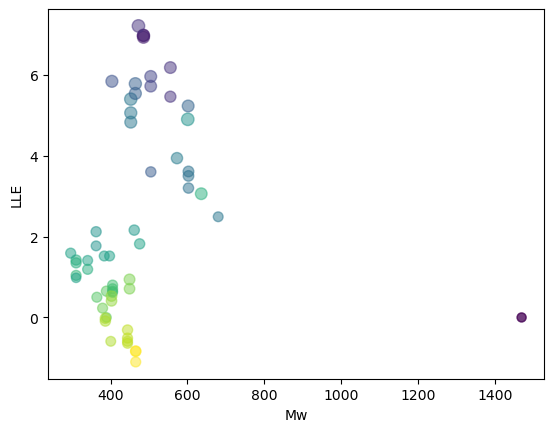

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Document ChEMBL IDでfiltering
# ddf = df[df['Document ChEMBL ID']=='CHEMBL4622984'].dropna(subset=['Ligand Efficiency LLE', 'Molecular Weight', 'pChEMBL Value'])

# %%
fig, ax = plt.subplots()
# ax.set_xticks([400, 600, 800])
ax.scatter(x=df['Molecular Weight'], 
            y=df['Ligand Efficiency LLE'].replace('','0'), 
            alpha=0.5,
            s=df['pChEMBL Value'] *10,
            c=df['AlogP']
            )
ax.set_xlabel("Mw")
ax.set_ylabel("LLE")
# ax.set_xlim([400,800])
plt.show()


### Plotly.go scatter

In [126]:
import plotly.graph_objects as go

data1 = go.Scatter(x=df['Molecular Weight'], 
                    y=df['pChEMBL Value'],
                    mode='markers',
                    # fill='Murcko_generic_SMILES'
                    )
go.Figure(data1)


### Plotly.px scatter

In [47]:
import plotly.express as px
fig = px.scatter(df,
                    x='Molecular Weight',
                    y='Ligand Efficiency LLE',
                    # color='AlogP',
                    color='Document ChEMBL ID',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    hover_name='Molecule ChEMBL ID',
                    hover_data=['Document ChEMBL ID', df.index],
                    opacity=0.5
                )
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 
fig.show()


### Plotly.3D scatter

In [50]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x='Molecular Weight',
                    z='pChEMBL Value',
                    y='AlogP',
                    color='Document ChEMBL ID',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    hover_name='Molecule ChEMBL ID',
                    hover_data=['Molecule ChEMBL ID',df.index],
                    opacity=0.5)
fig.update_layout(
    # showlegend=False, # Legendのon/off
    width=1200,
    height=1000
    ) 
fig.show()

### Plotly.violin

In [35]:
fig = px.violin(df,
                x='Document ChEMBL ID',
                y='Ligand Efficiency LLE',
                color='Document ChEMBL ID',
                box=True,
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value']
                )
fig.update_layout(
    title='pValue v.s. Document ChEMBL ID',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 

fig.show()

### Plotly.box

In [51]:
fig = px.box(df,
                y='Ligand Efficiency LLE',
                x='Document ChEMBL ID',
                color='Document ChEMBL ID',
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value', df.index]
                )
fig.update_layout(
    title='LLE v.s. Document ChEMBL ID',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    ) 

fig.show()

### matplotlib.mouseover

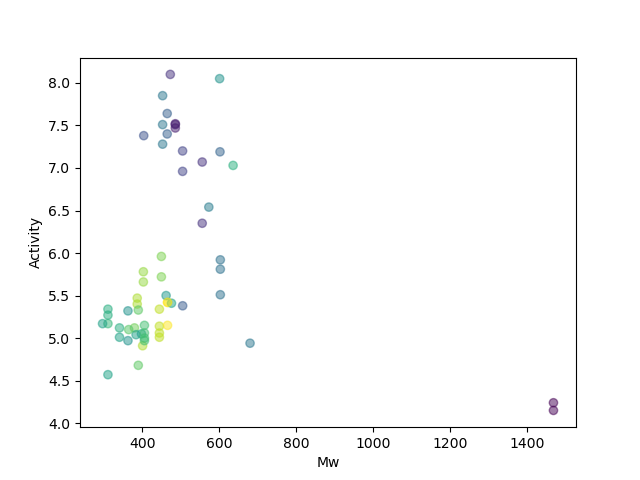

In [8]:
# https://choron81.hatenablog.com/entry/2022/11/30/000000
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

mols = [Chem.MolFromSmiles(Smile) for Smile in df["Smiles"]]
ims=[Draw.MolToImage(mol) for mol in mols]

# %%
fig, ax = plt.subplots()
imagebox = OffsetImage(ims[0], zoom=0.3)
imagebox.image.axes = ax

annot = AnnotationBbox(imagebox,
                       xy=(0,0),
                       xybox=(60,-60),
                       xycoords="data",
                       boxcoords="offset points",
                       pad=0.5,
                       arrowprops=dict( arrowstyle="->"))
annot.set_visible(False)
ax.add_artist(annot)
    
x = df["Molecular Weight"]#x軸は分子量。
y = df["pChEMBL Value"]#y軸は活性値。
colors = df["AlogP"]#色はAlogP。
sc = plt.scatter(x, y, c=colors, alpha=0.5)

def update_annot(ind):
    i = ind["ind"][0]
    pos = sc.get_offsets()[i]
    annot.xy = (pos[0], pos[1])
    imagebox.set_data(ims[i])

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

ax.set_xlabel("Mw")
ax.set_ylabel("Activity")
# plt.yscale('log')#y軸は対数軸にした。

# fig.colorbar(sc, ax=ax)#カラーバーを付けた。

plt.show()



### Drawing molecules

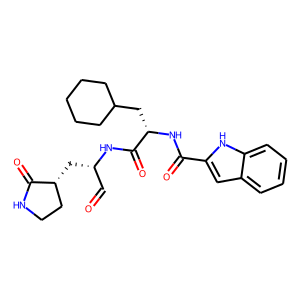

In [141]:
Draw.MolToImage(df['Molecule_Image'].iloc[58])

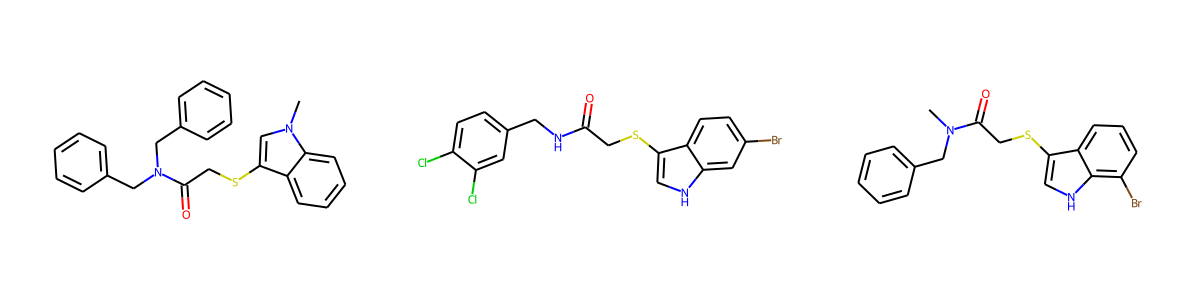

In [82]:
Draw.MolsToGridImage(df['Molecule_Image'].iloc[0:3],
                        molsPerRow=3,
                        subImgSize=(400,300)
                        )

### Filtering by Document ChEMBLE ID

In [111]:
# filtering with Document ChEMBLE ID CHEMBL4808212
DocID = input('Document ChEMBL ID?')
ddf = df[df['Document ChEMBL ID']==DocID]

### Viewing top 3 compounds

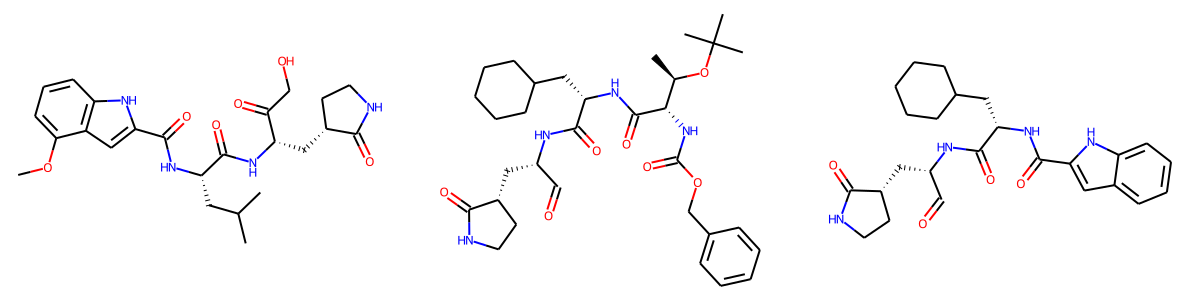

In [113]:
Draw.MolsToGridImage(ddf.sort_values('pChEMBL Value', ascending=False)['Molecule_Image'].iloc[0:3],
                        molsPerRow=3,
                        subImgSize=(400,300),
                        )

### show summary table

,Molecule Name,Molecule ChEMBL ID,Molecule_Image,pChEMBL Value,AlogP,#RO5 Violations,Assay Description,Document ChEMBL ID
0,NaN,CHEMBL4864930,,4.91,5.50,1,Inhibition of SARS-CoV-2 RdRp transfected in h...,CHEMBL4831483
1,NaN,CHEMBL4846173,,5.06,5.65,1,Inhibition of SARS-CoV-2 RdRp transfected in h...,CHEMBL4831483
2,NaN,CHEMBL4854368,,4.68,4.68,0,Inhibition of SARS-CoV-2 RdRp transfected in h...,CHEMBL4831483

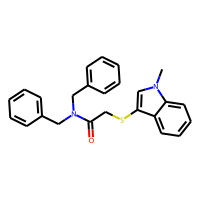
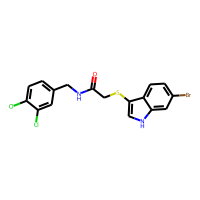
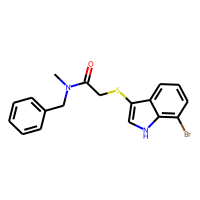

In [94]:
ddf.filter(items=['Molecule Name', 
                 'Molecule ChEMBL ID',
                 'Molecule_Image',
                 'Moleculer Weight',
                 'pChEMBL Value',
                 'AlogP',
                 'Ligand effieicncy LLE',
                 '#RO5 Violations',
                 'Assay Description',
                 'Document ChEMBL ID'
                 ]).head(3)


### Save summary csv

In [145]:
ddf.filter(items=['Molecule Name', 
                 'Molecule ChEMBL ID',
                 'Smiles',
                 'Moleculer Weight',
                 'pChEMBL Value',
                 'AlogP',
                 'Ligand effieicncy LLE',
                 '#RO5 Violations',
                 'Assay Description',
                 'Document ChEMBL ID'
                 ]).to_csv('test2.csv')


### Plotly.scatter

In [132]:
import plotly.express as px
fig = px.scatter(ddf,
                    x='Molecular Weight',
                    y='Ligand Efficiency LLE',
                    # color='AlogP',
                    color='Murcko_SMILES',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    hover_name='Molecule ChEMBL ID',
                    hover_data=['Murcko_SMILES', ddf.index],
                    opacity=0.5
                )
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=1400,
    # height=700
    ) 
fig.show()


### Plotly.box

In [138]:
fig = px.box(ddf,
                x='Ligand Efficiency LLE',
                y='Murcko_SMILES',
                color='Murcko_SMILES',
                points='all',
                hover_data=['Molecular Weight', 'AlogP', 'pChEMBL Value', ddf.index]
                )
fig.update_layout(
    title='LLE v.s. Document ChEMBL ID',
    showlegend=False, # Legendのon/off
    width=1600,
    # height=800
    ) 

fig.show()

##### add pdb id
##### pymol